In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from sklearn import metrics

In [2]:
norm_RBP = 'RBP200828A305|RBP200828A123|RBP201022A161|RBP201022A115'
fast_RBP = 'RBP201112A039|RBP201112A040|RBP201112A041|RBP201112A176'
labels = ['0-0.01', '0.01-1', '1-10', '10-100', '>100']

rbp_map = {'RBP200828A305': 'RBP201112A039',
           'RBP200828A123': 'RBP201112A040',
           'RBP201022A161': 'RBP201112A041',
           'RBP201022A115': 'RBP201112A176'}

# Data Wrangling

In [3]:
df = pd.read_pickle(
    '/ghds/groups/labdesk/bshih/c19dash/c19_dashboard/c19_call.pickle').dropna(how='all', axis=1)
df = df[(df['sample_type'] != 'NTC') & (df['sample_type'] != 'Positive')]
df = df[df['pos_tube_rack'].str.match(r'.*?(A6|B5)') == False]

df['date'] = (df.runid.str[2:4] +
              '-' + df.runid.str[4:6] +
              '-' + df.runid.str[:2]).astype(np.datetime64)
df['RBP'] = df['pos_tube_rack'].str.split(pat=':').str[0]
df['well'] = df['pos_tube_rack'].str.split(pat=':').str[1]
df['row'] = df['pos_tube_rack'].str[14]
df['column'] = df['pos_tube_rack'].str.extract(r'.*?:[A-H](\d+)').astype('int')
df['sample_count'] = 1

df['total_detected'] = df['call'].map({'not_detected': 0,
                                       'detected': 1,
                                       'no_call': 0})

df['category'] = pd.cut(df['median_covid_ratio'],
                        [-np.inf, 0.01, 1, 10, 100, np.inf], labels=labels)
dummies = pd.get_dummies(df.category)
df = pd.concat([df, dummies], axis=1)

## Create Normal Extraction df ##
df_norm = df[df['RBP'].str.contains(norm_RBP)].sort_values(
    by=['date', 'row', 'column'], ascending=True).dropna(how='all', axis=1)
df_norm['mapping'] = df_norm.RBP.map(rbp_map)

## Create FAST Extraction df ##
dropped_RBP = ['RBP201112A039', 'RBP201112A176']
dropped_wells = ['D12', 'E12', 'F12', 'G12', 'H12']

df_fast = df[df['RBP'].str.contains(fast_RBP)].sort_values(
    by=['RBP', 'row', 'column'], ascending=True).dropna(how='all', axis=1)
df_fast = df_fast[~((df_fast['RBP'].isin(dropped_RBP)) &
                    (df_fast['well'].isin(dropped_wells)))]

## Merge Normal and FAST df on RBP Mapping and Well ##
combined = pd.merge(df_norm, df_fast, how='outer', left_on=['mapping', 'well'], right_on=['RBP', 'well'],
                    suffixes=('_norm', '_fast'))

# PPA/NPA

In [4]:
binning_norm = combined.groupby('RBP_norm', sort=False).agg({'sample_count_norm': 'sum',
                                                             'date_norm': 'max',
                                                             'total_detected_norm': 'sum',
                                                             '0-0.01_norm': 'sum',
                                                             '0.01-1_norm': 'sum',
                                                             '1-10_norm': 'sum',
                                                             '10-100_norm': 'sum',
                                                             '>100_norm': 'sum'})
binning_norm

,sample_count_norm,date_norm,total_detected_norm,0-0.01_norm,0.01-1_norm,1-10_norm,10-100_norm,>100_norm
RBP_norm,,,,,,,,
RBP200828A305,87,2020-10-20,12,75,2,2,0,8
RBP200828A123,92,2020-10-27,13,79,3,0,4,6
RBP201022A161,92,2020-11-07,12,80,4,5,1,2
RBP201022A115,87,2020-11-10,30,57,15,2,2,11


In [5]:
binning_fast = combined.groupby('RBP_fast', sort=False).agg({'sample_count_fast': 'sum',
                                                             'date_fast': 'max',
                                                             'total_detected_fast': 'sum',
                                                             '0-0.01_fast': 'sum',
                                                             '0.01-1_fast': 'sum',
                                                             '1-10_fast': 'sum',
                                                             '10-100_fast': 'sum',
                                                             '>100_fast': 'sum'})
binning_fast

,sample_count_fast,date_fast,total_detected_fast,0-0.01_fast,0.01-1_fast,1-10_fast,10-100_fast,>100_fast
RBP_fast,,,,,,,,
RBP201112A039,87,2020-12-09,12,75,3,1,0,8
RBP201112A040,92,2020-12-09,14,78,4,0,3,7
RBP201112A041,92,2020-12-09,11,81,4,4,1,2
RBP201112A176,87,2020-12-09,29,58,15,2,3,9


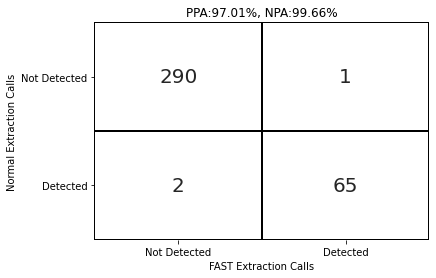

In [6]:
true_calls = list(combined.total_detected_norm.values)
fast_calls = list(combined.total_detected_fast.values)

cf_matrix = metrics.confusion_matrix(true_calls, fast_calls)
ax = sns.heatmap(cf_matrix, cmap=ListedColormap(['white']),
                 annot=True, annot_kws={"size": 20}, fmt='d',
                 cbar=False, linewidths=1, linecolor='black')

ax.set_xticklabels(['Not Detected', 'Detected'])
ax.set_yticklabels(['Not Detected', 'Detected'])
ax.set_xlabel('FAST Extraction Calls')
ax.set_ylabel('Normal Extraction Calls')

tn, fp, fn, tp = cf_matrix.ravel()

plt.title(f'PPA:{(tp*100/(tp+fn)):.2f}%, NPA:{(tn*100/(tn+fp)):.2f}%')

plt.yticks(rotation=0)
plt.show()

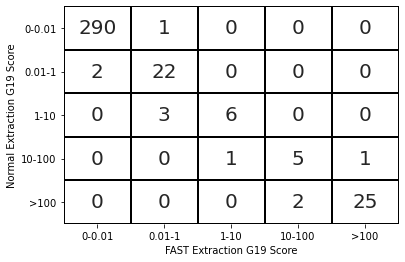

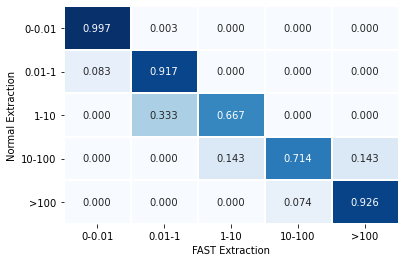

In [7]:
true_calls = list(combined.category_norm.values)
fast_calls = list(combined.category_fast.values)

cf_matrix = metrics.confusion_matrix(true_calls, fast_calls)
ax = sns.heatmap(cf_matrix, cmap=ListedColormap(['white']),
                 annot=True, annot_kws={"size": 20}, fmt='d',
                 cbar=False, linewidths=1, linecolor='black')

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('FAST Extraction G19 Score')
ax.set_ylabel('Normal Extraction G19 Score')

plt.yticks(rotation=0)
plt.show()

cf_matrix = metrics.confusion_matrix(true_calls, fast_calls, normalize='true')
ax2 = sns.heatmap(cf_matrix, cmap='Blues', annot=True,
                  linewidths=1, fmt='.3f', cbar=False)
ax2.set_xticklabels(labels)
ax2.set_yticklabels(labels)
ax2.set_xlabel('FAST Extraction')
ax2.set_ylabel('Normal Extraction')

plt.yticks(rotation=0)
plt.show()

# Plate Comparison

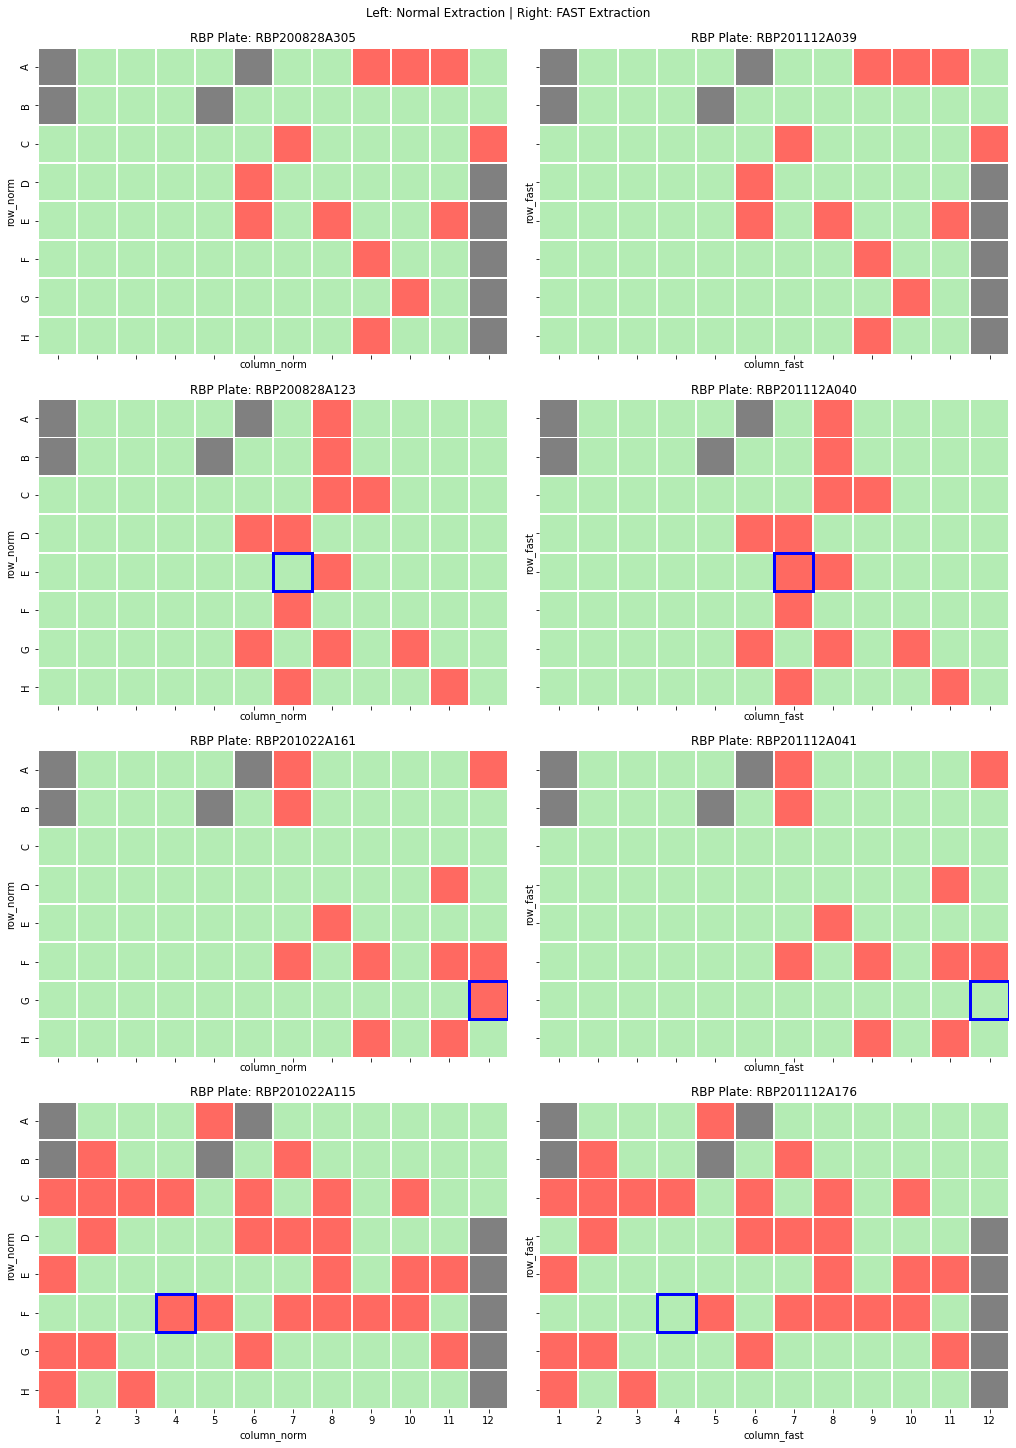

In [8]:
total_cols = 2
total_rows = 4

fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols, sharex=True, sharey=True,
                        figsize=(7*total_cols, 5*total_rows), constrained_layout=True, squeeze=False)

fig.suptitle(f'Left: Normal Extraction | Right: FAST Extraction')
fig.set_facecolor('white')
ax.tick_params(direction='out', length=6, color='black')

row_to_num = {'A': 0, 'B': 1, 'C': 2, 'D': 3,
              'E': 4, 'F': 5, 'G': 6, 'H': 7}

for i, j, k in zip(combined.RBP_norm.unique(), combined.RBP_fast.unique(), range(4)):

    norm = combined[combined['RBP_norm'] == i]
    norm_pivot = norm.pivot(
        index='row_norm', columns='column_norm', values='total_detected_norm')
    mask_norm = norm_pivot.isnull()

    norm_fig = sns.heatmap(norm_pivot, cbar=False, cmap=ListedColormap(
        ['#b4ecb4', '#ff6961']), ax=axs[k][0], mask=mask_norm, linewidths=1)
    norm_fig.set_facecolor('grey')

    axs[k][0].set_title(f'RBP Plate: {i}')

    fast = combined[combined['RBP_fast'] == j]
    fast_pivot = fast.pivot(
        index='row_fast', columns='column_fast', values='total_detected_fast')
    mask_fast = fast_pivot.isnull()

    fast_fig = sns.heatmap(fast_pivot, cbar=False, cmap=ListedColormap(
        ['#b4ecb4', '#ff6961']), ax=axs[k][1], mask=mask_fast, linewidths=1)
    fast_fig.set_facecolor('grey')
    axs[k][1].set_title(f'RBP Plate: {j}')

    for i in norm[norm['total_detected_norm'].values != fast['total_detected_fast'].values].loc[:, ['row_norm', 'column_norm']].values:
        norm_fig.add_patch(Rectangle(
            (i[1] - 1, row_to_num[i[0]]), 1, 1, fill=False, edgecolor='blue', lw=3))
        fast_fig.add_patch(Rectangle(
            (i[1] - 1, row_to_num[i[0]]), 1, 1, fill=False, edgecolor='blue', lw=3))

# fig.savefig('fastconcordance1.png', dpi=300)

### Discordant Wells

In [9]:
combined[(combined['total_detected_norm'] != combined['total_detected_fast'])]\
    .loc[:, ['well', 'median_covid_ratio_norm', 'median_covid_ratio_fast']]

,well,median_covid_ratio_norm,median_covid_ratio_fast
137,E7,0.00164,0.01908
258,G12,0.01488,0.00000
328,F4,0.08609,0.00000


### Normal Covid Score vs FAST Covid Score

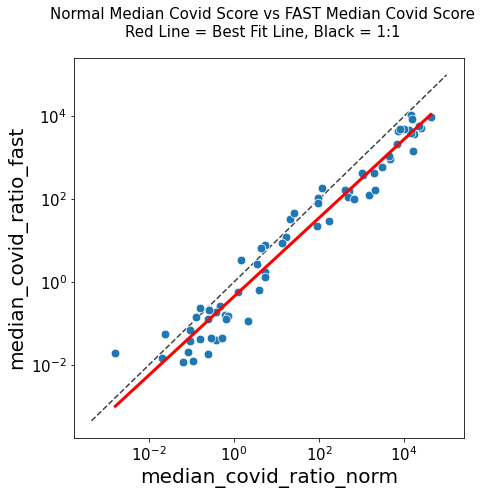

In [10]:
score_relation = combined.query("(total_detected_norm == 1 | total_detected_fast == 1) & \
                                 (median_covid_ratio_norm > 0 & median_covid_ratio_fast > 0)")

fig, ax = plt.subplots(figsize=(7, 7))
fig.set_facecolor('white')
ax.set(xscale='log', yscale='log')

sns.scatterplot(data=score_relation, x='median_covid_ratio_norm',
                y='median_covid_ratio_fast', s=75)

x = score_relation['median_covid_ratio_norm'].values
y = score_relation['median_covid_ratio_fast'].values

new_x, new_y = zip(*sorted(zip(x, y)))

logA = np.log(new_x)
logB = np.log(new_y)

m, c = np.polyfit(logA, logB, 1)
y_fit = np.exp(m*logA + c)
plt.plot(new_x, y_fit, 'r', linewidth=3)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)

plt.setp(ax.get_xticklabels(), fontsize=15)
plt.setp(ax.get_yticklabels(), fontsize=15)

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
fig.suptitle('Normal Median Covid Score vs FAST Median Covid Score\n\
Red Line = Best Fit Line, Black = 1:1', fontsize=15)

plt.show()

In [11]:
## Look at Singlicate for Discordant Wells ##
singlicate = pd.read_pickle(
    "/ghds/groups/labdesk/bshih/c19dash/c19_dashboard/c19_read_counts.pickle")

singlicate_norm = singlicate[singlicate['run_sample_id'].isin(
    combined.run_sample_id_norm.values)].dropna(how='all', axis=1)
singlicate_fast = singlicate[singlicate['run_sample_id'].isin(
    combined.run_sample_id_fast.values)].dropna(how='all', axis=1)

singlicate_norm['date'] = (singlicate_norm.runid.str[2:4] +
                           '-' + singlicate_norm.runid.str[4:6] +
                           '-' + singlicate_norm.runid.str[:2]).astype(np.datetime64)
singlicate_norm['well'] = singlicate_norm['pos_tube_rack'].str.split(
    pat=':').str[1]

singlicate_fast['RBP'] = singlicate_fast['pos_tube_rack'].str.split(
    pat=':').str[0]

## Create Table of Discordant Sample ID for Normal and FAST ##
discordant = combined[(combined['total_detected_norm'] != combined['total_detected_fast'])].loc[:, [
    'run_sample_id_norm', 'run_sample_id_fast']]

## Find Discordant Samples for Normal and FAST ##
single_norm = singlicate_norm[singlicate_norm['run_sample_id'].isin(discordant.run_sample_id_norm.values)]\
    .sort_values(by=['date', 'covid_ratio']).add_suffix('_norm').loc[:, ['well_norm', 'covid_ratio_norm']]
single_norm = single_norm.loc[:, [
    'well_norm', 'covid_ratio_norm']].reset_index()

single_fast = singlicate_fast[singlicate_fast['run_sample_id'].isin(discordant.run_sample_id_fast.values)]\
    .sort_values(by=['RBP', 'covid_ratio']).add_suffix('_fast')
single_fast = single_fast.loc[:, ['covid_ratio_fast']].reset_index()

## Concat Discordant Samples into one df ##
single_discord = pd.concat(
    [single_norm, single_fast], axis=1).drop(columns='index')
single_discord

,well_norm,covid_ratio_norm,covid_ratio_fast
0,E7,0.00000,0.01784
1,E7,0.00164,0.01908
2,E7,0.03350,0.02176
3,G12,0.00000,0.00000
4,G12,0.01488,0.00000
5,G12,0.03034,0.00000
6,F4,0.07765,0.00000
7,F4,0.08609,0.00000
8,F4,0.11880,0.00000
